In [18]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats

# 2)
## b)

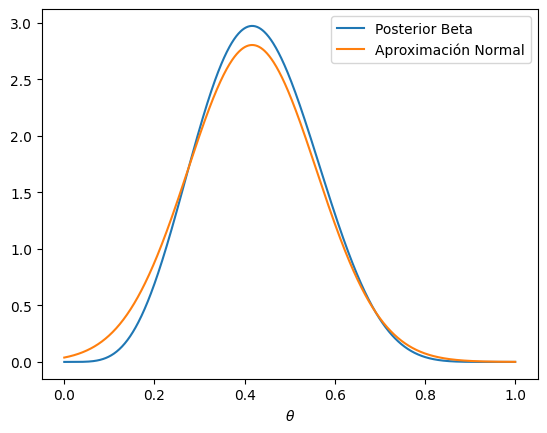

In [36]:
k = 4
n = 10
alpha = 2
beta = 2

# posterior teorica
theta = np.linspace(0, 1, 1000)
alpha_posteiro = alpha + k
beta_posterior = beta + n - k
posterior = stats.beta.pdf(theta, alpha_posteiro, beta_posterior)

# aprox cuadratica
theta_hat = (alpha_posteiro - 1) / (alpha_posteiro + beta_posterior - 2) # moda
var_hat = 1 / (((alpha_posteiro - 1) / (theta_hat**2)) + ((beta_posterior - 1) / (1 - theta_hat)**2))
aproximacion_normal = stats.norm.pdf(theta, theta_hat, np.sqrt(var_hat))

# grafico
plt.plot(theta, posterior, label='Posterior Beta')
plt.plot(theta, aproximacion_normal, label='Aproximación Normal')
plt.xlabel('$\\theta$')
plt.legend()
plt.show()

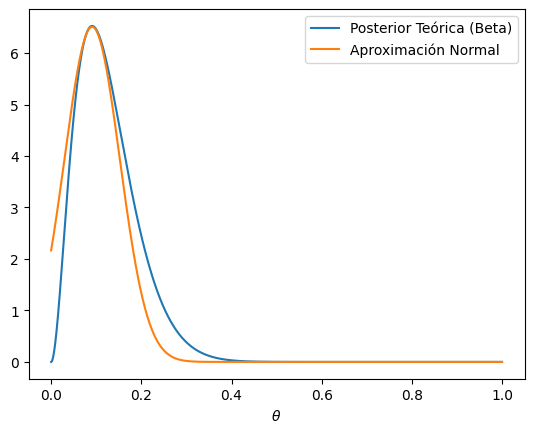

In [62]:
def probar_distintos_n_k(n: int, k: int):
    alpha = 2
    beta = 2

    # posterior teorica
    theta = np.linspace(0, 1, 1000)
    alpha_posteiro = alpha + k
    beta_posterior = beta + n - k
    posterior = stats.beta.pdf(theta, alpha_posteiro, beta_posterior)

    # aprox cuadratica
    theta_hat = (alpha_posteiro - 1) / (alpha_posteiro + beta_posterior - 2) # moda
    var_hat = 1 / (((alpha_posteiro - 1) / (theta_hat**2)) + ((beta_posterior - 1) / (1 - theta_hat)**2))
    aproximacion_normal = stats.norm.pdf(theta, theta_hat, np.sqrt(var_hat))

    # grafico
    plt.plot(theta, posterior, label='Posterior Teórica (Beta)')
    plt.plot(theta, aproximacion_normal, label='Aproximación Normal')
    plt.xlabel('$\\theta$')
    plt.legend()
    plt.show()

probar_distintos_n_k(20, 1)

La aproximación normal queda "cortada" cuando me acerco a los extremos ya que siempre es simetrica y el mu esta muy cerca del borde.
Intuyo que por ahí esta la razón de porqué no conviene usarla, pero no sabría dar una explicación más técnica.

# 4)

In [7]:
df = pd.read_csv('data-parcial2.csv')
df.head()

,Horas,Nota
0,55.332537,6.958527
1,71.803747,5.276655
2,60.673574,9.476582
3,54.943435,3.250237
4,42.941825,4.999714


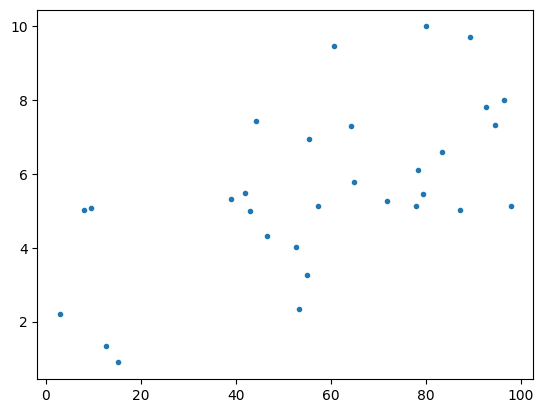

In [9]:
plt.plot(df['Horas'], df['Nota'], '.')

## a)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, epsilon]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 166 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'epsilon'}>,
        <Axes: title={'center': 'epsilon'}>]], dtype=object)

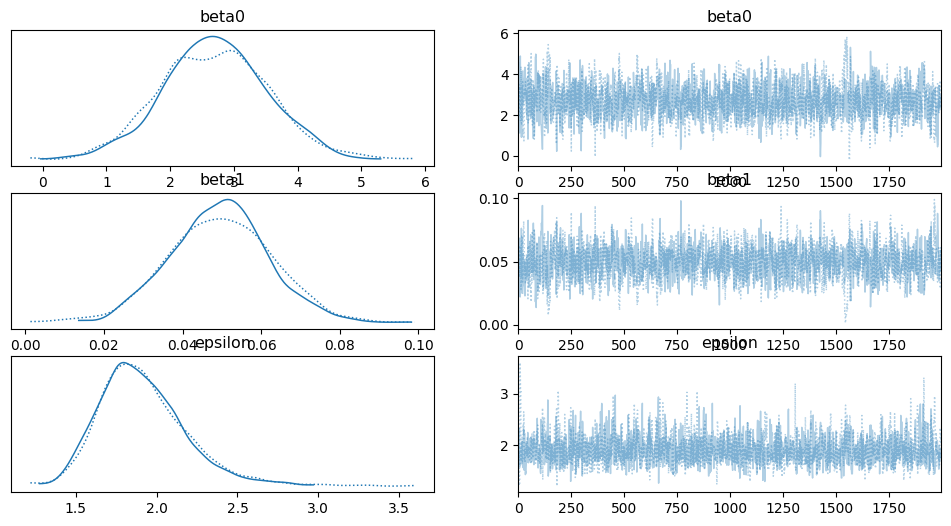

In [15]:
with pm.Model() as modelo_lineal:
    
    beta0 = pm.Uniform('beta0', -10, 10)
    beta1 = pm.Uniform('beta1', 0, 5)
    epsilon = pm.Uniform('epsilon', 0, 10)
    
    mu = beta0 + beta1*df.Horas.values
    nota = pm.Normal('nota', mu=mu, sigma=epsilon, observed=df.Nota)

    trace = pm.sample(2000)
az.plot_trace(trace)

array([<Axes: title={'center': 'beta0'}>,
       <Axes: title={'center': 'beta1'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

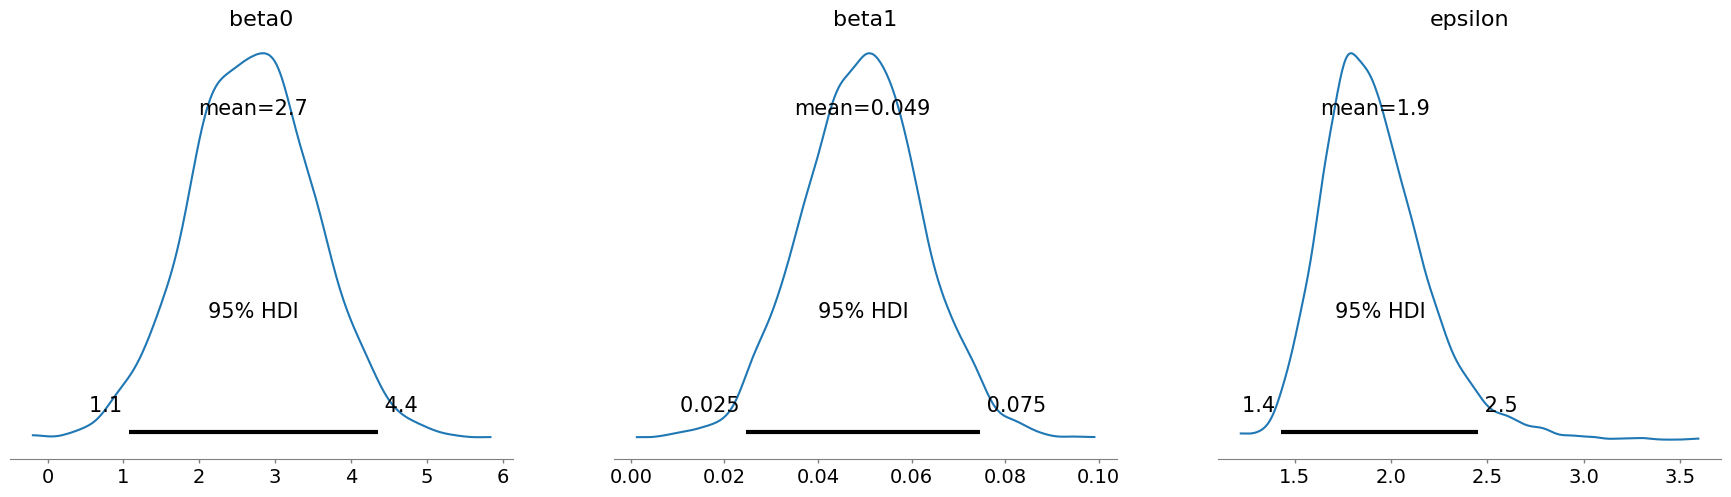

In [17]:
# muestro las posteriors de los parámetros

az.plot_posterior(trace)

## b)

(array([  1.,   0.,   0.,   1.,   1.,   3.,   4.,   6.,  11.,  26.,  32.,
         39.,  64.,  75.,  87.,  85., 105., 103.,  86.,  79.,  53.,  53.,
         27.,  21.,  14.,   6.,   7.,   7.,   2.,   2.]),
 array([-2.78387551, -2.30227494, -1.82067436, -1.33907378, -0.85747321,
        -0.37587263,  0.10572795,  0.58732853,  1.0689291 ,  1.55052968,
         2.03213026,  2.51373083,  2.99533141,  3.47693199,  3.95853256,
         4.44013314,  4.92173372,  5.40333429,  5.88493487,  6.36653545,
         6.84813603,  7.3297366 ,  7.81133718,  8.29293776,  8.77453833,
         9.25613891,  9.73773949, 10.21934006, 10.70094064, 11.18254122,
        11.6641418 ]),
 <BarContainer object of 30 artists>)

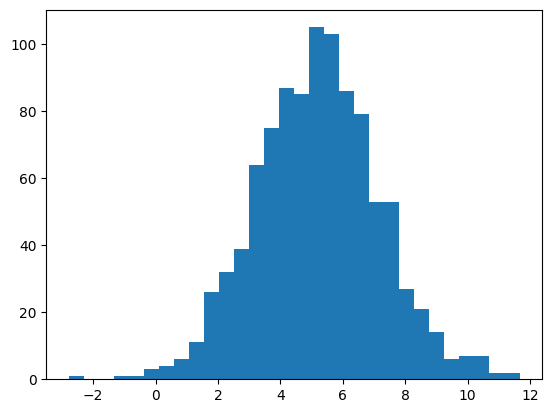

In [22]:
# posterior predictive

betas0 = trace.posterior['beta0'].values.flatten()
betas1 = trace.posterior['beta1'].values.flatten()
epsilons = trace.posterior['epsilon'].values.flatten()

horas = 50

iters = 1000
notas = np.zeros(iters)
for i in range(iters):
    index = np.random.choice(range(len(betas0)))
    beta0 = betas0[index]
    beta1 = betas1[index]
    epsilon = epsilons[index]
    mu = beta0 + beta1*horas
    notas[i] = stats.norm.rvs(mu, epsilon)

plt.hist(notas, bins = 30)

{'bodies': [<matplotlib.collections.PolyCollection at 0x1fc13be53d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1fc0f85da00>,
 'cmins': <matplotlib.collections.LineCollection at 0x1fc0f4efd10>,
 'cbars': <matplotlib.collections.LineCollection at 0x1fc14f58e30>}

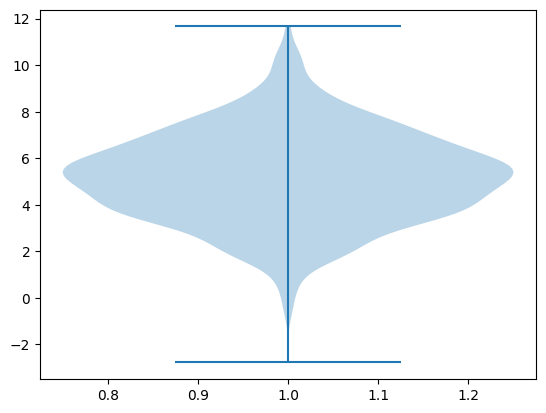

In [23]:
plt.violinplot(notas)

In [27]:
# hdi 90%
hdi = az.hdi(notas, hdi_prob=0.90)
print(hdi)

[1.66945423 8.01356003]


Creo que este es el item c), no tengo clara la diferencia.